In [202]:
import duckdb
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

path = "/home/etienne/projects/obsq/work/dev/data/data.duckdb"
target = 'score'
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [203]:
table = 'main'
schema = 'score'
con = duckdb.connect(path)
df = con.execute(f"""SELECT* FROM {schema}.{table}""" ).df()
#df = df.drop(columns= 'geom')
con.close()

In [204]:
df.set_index('gbifID', inplace=True)

In [205]:
missing_values_count = df.isnull().sum()
missing_values_count

score                                 0
observer_pca0                         0
observer_pca1                         0
observer_inat_pca0                    0
observer_inat_pca1                    0
taxo_confusability_index              0
cmva_id_count                         0
cmva_id_agree_rate                    0
cmva_id_time                          0
cmva_expert_id                        0
meta_media_count                      0
meta_coordinateUncertaintyInMeters    0
meta_pheno_repro                      0
meta_pheno_leaves                     0
meta_pheno_sex                        0
meta_occurrenceRemarks                0
species_encoded                       0
histo_taxon_ttl_obs_count             0
histo_taxon_obs_month_density         0
tempo_day                             0
tempo_month                           0
tempo_year                            0
spatial_cluster                       0
gee_pca0                              0
gee_pca1                              0


In [206]:
X = df.drop(columns=[target])
y = df.pop(target)
X.head()

,observer_pca0,observer_pca1,observer_inat_pca0,observer_inat_pca1,taxo_confusability_index,cmva_id_count,cmva_id_agree_rate,cmva_id_time,cmva_expert_id,meta_media_count,...,tempo_year,spatial_cluster,gee_pca0,gee_pca1,gee_pca2,gee_pca3,range,pheno_leaves_month_density,pheno_repro_month_density,pheno_sex_month_density
gbifID,,,,,,,,,,,,,,,,,,,,,
5759678836,-149.22806,669.10008,1.15702,0.13427,24,1,1.00000,28,0,5,...,2025,3,580.36551,14.24096,-51.51520,11.17725,1,0.14900,0.14800,0.00000
5281917703,-151.98903,238.79153,1.02641,0.05380,0,1,1.00000,28,0,3,...,2025,4,-151.84323,11.67484,-34.23369,-4.00689,1,0.00000,0.00000,0.00000
5153337226,-149.22806,669.10008,1.15702,0.13427,24,1,1.00000,11,0,1,...,2025,3,3.15537,26.66347,17.43068,-5.50776,1,0.09100,0.08800,0.00000
3881842680,-144.47286,42.51221,1.00330,0.07428,18,1,1.00000,1,0,1,...,2022,4,-147.25614,8.70386,-25.84255,2.66001,1,0.10500,0.23100,0.00000
5133154487,-132.60511,154.34584,1.11569,0.07214,14,1,1.00000,0,0,4,...,2025,4,-157.33089,-0.48277,-11.28435,4.12516,1,0.66700,0.00000,0.00000


In [207]:
score_values = pd.DataFrame(y)
score_values.describe()

,score
count,36323.00000
mean,0.65077
std,0.36604
min,0.00000
25%,0.37712
50%,0.56090
75%,0.85250
max,2.14116


<Axes: ylabel='Count'>

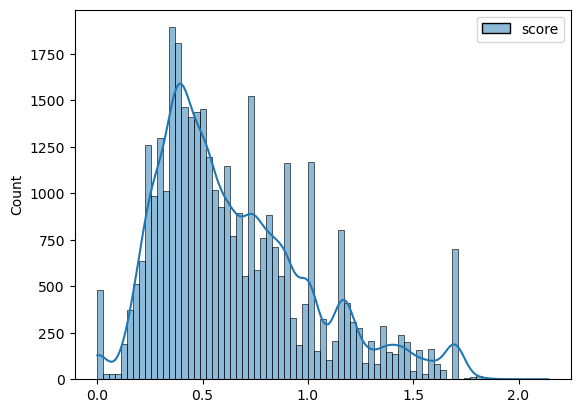

In [208]:
sns.histplot(score_values, kde=True)

<Axes: >

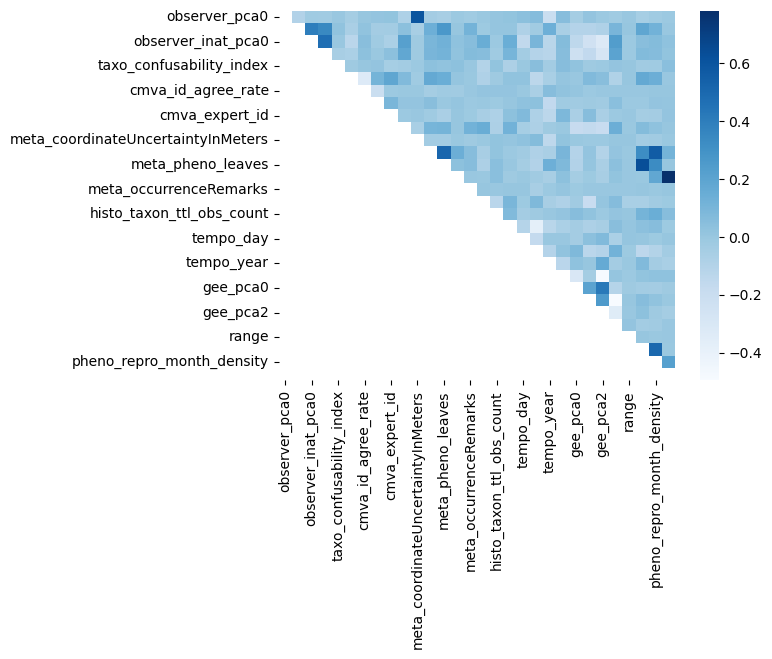

In [209]:
corr = X.corr(numeric_only=True)
upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

sns.heatmap(upper_tri, cmap='Blues',)

In [210]:
highly_correlated_pairs = upper_tri.stack().sort_values(ascending=False)
highly_correlated_pairs

meta_pheno_sex                 pheno_sex_month_density               0.78160
meta_pheno_leaves              pheno_leaves_month_density            0.63500
observer_pca0                  meta_coordinateUncertaintyInMeters    0.59868
meta_pheno_repro               pheno_repro_month_density             0.56383
                               meta_pheno_leaves                     0.51666
                                                                      ...   
cmva_id_count                  cmva_id_agree_rate                   -0.33035
gee_pca2                       gee_pca3                             -0.34511
histo_taxon_obs_month_density  tempo_month                          -0.37424
spatial_cluster                gee_pca2                             -0.48815
gee_pca1                       gee_pca3                             -0.49592
Length: 435, dtype: float64

In [211]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
n_samples = len(y_train)
n_pos = y_train.sum()
n_neg = n_samples - n_pos
scale_pos_weight = n_neg / n_pos

In [213]:
model = LinearRegression()

In [214]:
model = RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
            )

In [215]:
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsam

In [216]:
y_pred = model.predict(X_test)

In [217]:
# Calculate evaluation metrics

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r_squared)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.01668797001548272
Mean Squared Error (MSE): 0.0022898717335771493
R-squared (R²): 0.9832207295847246
Root Mean Squared Error (RMSE): 0.04785260425073174


In [218]:
print(X_test.shape)
print(y_test.shape)

(9081, 30)
(9081,)


In [219]:
y_pred

array([0.58838496, 0.60558171, 0.82238943, ..., 0.02427168, 0.24942419,
       0.55807943])

In [220]:
results = X_test.copy()
results['true'] = y_test
results['predicted'] = y_pred


<Axes: xlabel='true', ylabel='predicted'>

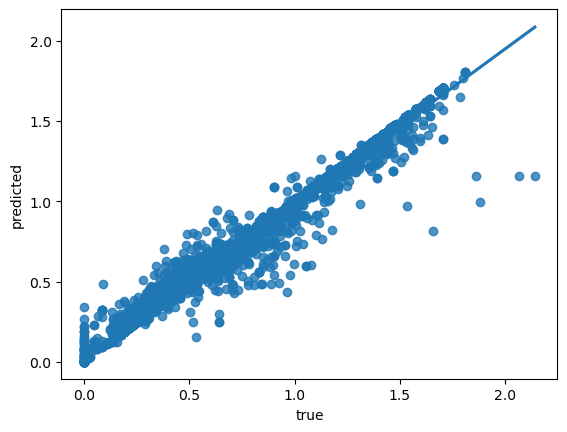

In [221]:
# Plot outputs
sns.regplot(results, x = 'true', y = 'predicted')

In [243]:
feature_names = [f"{i}" for i in X.columns.to_list()]
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

importances = model.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_std = pd.Series(std, index=feature_names)

forest_df = pd.DataFrame()
forest_df['importance'] = forest_importances
forest_df['std'] = forest_std

forest_df.head()


,importance,std
observer_pca0,0.02691,0.01131
observer_pca1,0.12496,0.07032
observer_inat_pca0,0.12487,0.07879
observer_inat_pca1,0.08459,0.06283
taxo_confusability_index,0.00264,0.00160


<ErrorbarContainer object of 3 artists>

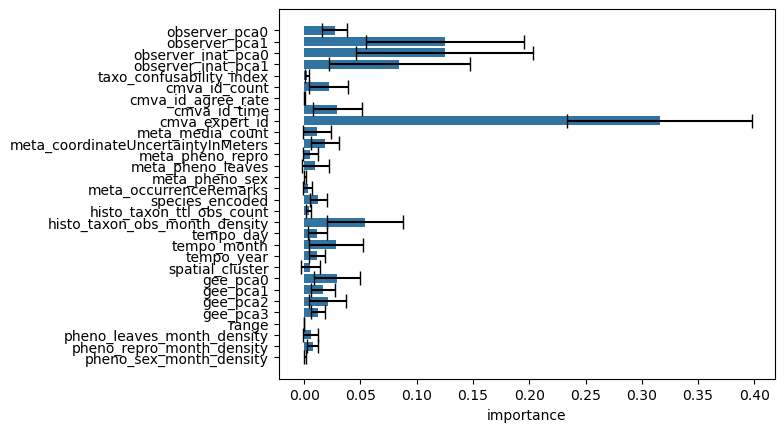

In [257]:
ax = sns.barplot(forest_df, y= feature_names, x= 'importance', errorbar=None)
ax.errorbar(y=range(len(feature_names)), x=forest_importances, xerr=forest_std, 
            fmt='none', c='black', capsize=5)

In [258]:
forest_importances.sort_values(ascending=False)

cmva_expert_id                       0.31583
observer_pca1                        0.12496
observer_inat_pca0                   0.12487
observer_inat_pca1                   0.08459
histo_taxon_obs_month_density        0.05408
cmva_id_time                         0.02940
gee_pca0                             0.02904
tempo_month                          0.02800
observer_pca0                        0.02691
cmva_id_count                        0.02193
gee_pca2                             0.02105
meta_coordinateUncertaintyInMeters   0.01859
gee_pca1                             0.01656
species_encoded                      0.01251
gee_pca3                             0.01237
tempo_day                            0.01167
tempo_year                           0.01135
meta_media_count                     0.01101
meta_pheno_leaves                    0.00987
pheno_repro_month_density            0.00739
pheno_leaves_month_density           0.00584
spatial_cluster                      0.00552
meta_pheno